# MODELADO: Clasificación de la adquisión

In [466]:
# Generales y preprocesamiento
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

# Preparación para modelos
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# Validación y guardado de modelos
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix , classification_report,  ConfusionMatrixDisplay, roc_auc_score
import pickle

import matplotlib.pyplot as plt
import warnings

# balanceo

from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours, TomekLinks



from modelado.funciones_modelado import *

In [467]:
# Carga de datos limpios
path_limpios = 'Datos/Limpios/'

df_clasif = carga_datos_limpios('df_clasif', path_limpios)
df_clasif_prefusion = carga_datos_limpios('df_clasif_prefusion', path_limpios)

In [468]:
df_clasif['Porcentaje_adquisicion_cat']=df_clasif['Porcentaje_adquisicion_cat'].astype('category')
df_clasif['Porcentaje_adquisicion_cat']=df_clasif['Porcentaje_adquisicion_cat'].cat.rename_categories([0,1,2])
df_clasif['Porcentaje_adquisicion_cat'].value_counts()

1    164
0    160
2     79
Name: Porcentaje_adquisicion_cat, dtype: int64

In [469]:
df_clasif_prefusion['Porcentaje_adquisicion_cat']=df_clasif_prefusion['Porcentaje_adquisicion_cat'].astype('category')
df_clasif_prefusion['Porcentaje_adquisicion_cat']=df_clasif_prefusion['Porcentaje_adquisicion_cat'].cat.rename_categories([0,1,2])
df_clasif_prefusion['Porcentaje_adquisicion_cat'].value_counts()

1    329
0    328
2    158
Name: Porcentaje_adquisicion_cat, dtype: int64

In [470]:
df_clasif.set_index("Codigo_NIF", inplace=True)

In [471]:
df_clasif.shape

(403, 66)

In [472]:
df_clasif_prefusion.shape

(815, 69)

In [473]:
df_clasif_prefusion = df_clasif_prefusion.drop(columns=['first_funding_date', 'last_funding_date','valuation_2022', 'Free capital mil EUR'])
df_clasif = df_clasif.drop(['index','ownerships'], axis=1)

In [474]:
RANDOM_STATE=42

## 1. Preprocesamiento

### 1.1 Limpieza de variables

In [475]:
df_clasif=quitar_variables_ident(df_clasif)
df_clasif_prefusion=quitar_variables_ident(df_clasif_prefusion)

### 1.2 Label Encoding de las categóricas

In [476]:
df_clasif = label_encoder_categoricas(df_clasif)
df_clasif_prefusion=label_encoder_categoricas(df_clasif_prefusion)

In [477]:
#seleccion_variables_clasif(df_clasif, df_clasif_prefusion)

### 1.3 Selección de variables

* Correlacion

In [478]:
# Observamos las correlaciones con la variable objetivo
correlaciones=df_clasif
correlaciones['Porcentaje_adquisicion_cat']=correlaciones['Porcentaje_adquisicion_cat'].astype(int)
correlaciones=df_clasif.corr()
correlaciones.loc[:,"Porcentaje_adquisicion_cat"].sort_values(ascending=False)

# no hay tan buena correlación

Porcentaje_adquisicion_cat                                1.000000
dias_operando                                             0.159506
Ratios de autonomía financiera a medio y largo plazo %    0.080240
EBITDA mil EUR                                            0.070244
Acreedores comerciales mil EUR                            0.067549
                                                            ...   
Free capital mil EUR                                           NaN
total_funding                                                  NaN
last_funding                                                   NaN
total_rounds                                                   NaN
dias_desde_ult_round                                           NaN
Name: Porcentaje_adquisicion_cat, Length: 64, dtype: float64

In [479]:
# Observamos las correlaciones con la variable objetivo

correlaciones=df_clasif_prefusion
correlaciones['Porcentaje_adquisicion_cat']=correlaciones['Porcentaje_adquisicion_cat'].astype(int)
correlaciones=df_clasif.corr()
correlaciones.loc[:,"Porcentaje_adquisicion_cat"].sort_values(ascending=False)

# no hay tan buena correlación

Porcentaje_adquisicion_cat                                1.000000
dias_operando                                             0.159506
Ratios de autonomía financiera a medio y largo plazo %    0.080240
EBITDA mil EUR                                            0.070244
Acreedores comerciales mil EUR                            0.067549
                                                            ...   
Free capital mil EUR                                           NaN
total_funding                                                  NaN
last_funding                                                   NaN
total_rounds                                                   NaN
dias_desde_ult_round                                           NaN
Name: Porcentaje_adquisicion_cat, Length: 64, dtype: float64

In [480]:
df_clasif_cor=vars_correlacion_clasif(df_clasif, 0.04)
df_clasif_pref_cor=vars_correlacion_clasif(df_clasif_prefusion, 0.08)

Hay 28 variables con una correlacion mayor a 0.04
Hay 25 variables con una correlacion mayor a 0.08


* Feature importance Random Forest

{'Capital social mil EUR': 0.0, 'Free capital mil EUR': 0.0, 'total_funding': 0.0, 'last_funding': 0.0, 'last_round': 0.01, 'total_rounds': 0.0, 'b2b_b2c': 0.0, 'revenue_models': 0.01, 'growth_stage': 0.02, 'company_status': 0.01, 'Número empleados': 0.02, 'Inmovilizado mil EUR': 0.03, 'Activo circulante mil EUR': 0.02, 'Total activo mil EUR': 0.02, 'Fondos propios mil EUR': 0.02, 'Pasivo fijo mil EUR': 0.02, 'Pasivo líquido mil EUR': 0.02, 'Total pasivo y capital propio mil EUR': 0.02, 'Resultado Explotación mil EUR': 0.02, 'Resultado financiero mil EUR': 0.02, 'Resultado del Ejercicio mil EUR': 0.02, 'Costes de los trabajadores / Ingresos de explotación (%) %': 0.02, 'Tesorería mil EUR': 0.02, 'Cash flow mil EUR': 0.02, 'Período de cobro (días) días': 0.02, 'Valor agregado mil EUR': 0.02, 'Apalancamiento (%) %': 0.02, 'Endeudamiento (%) %': 0.02, 'Margen de beneficio (%) %': 0.02, 'Ratio de liquidez %': 0.01, 'Ratio de solvencia %': 0.01, 'Rentabilidad económica (%) %': 0.02, 'Rentab

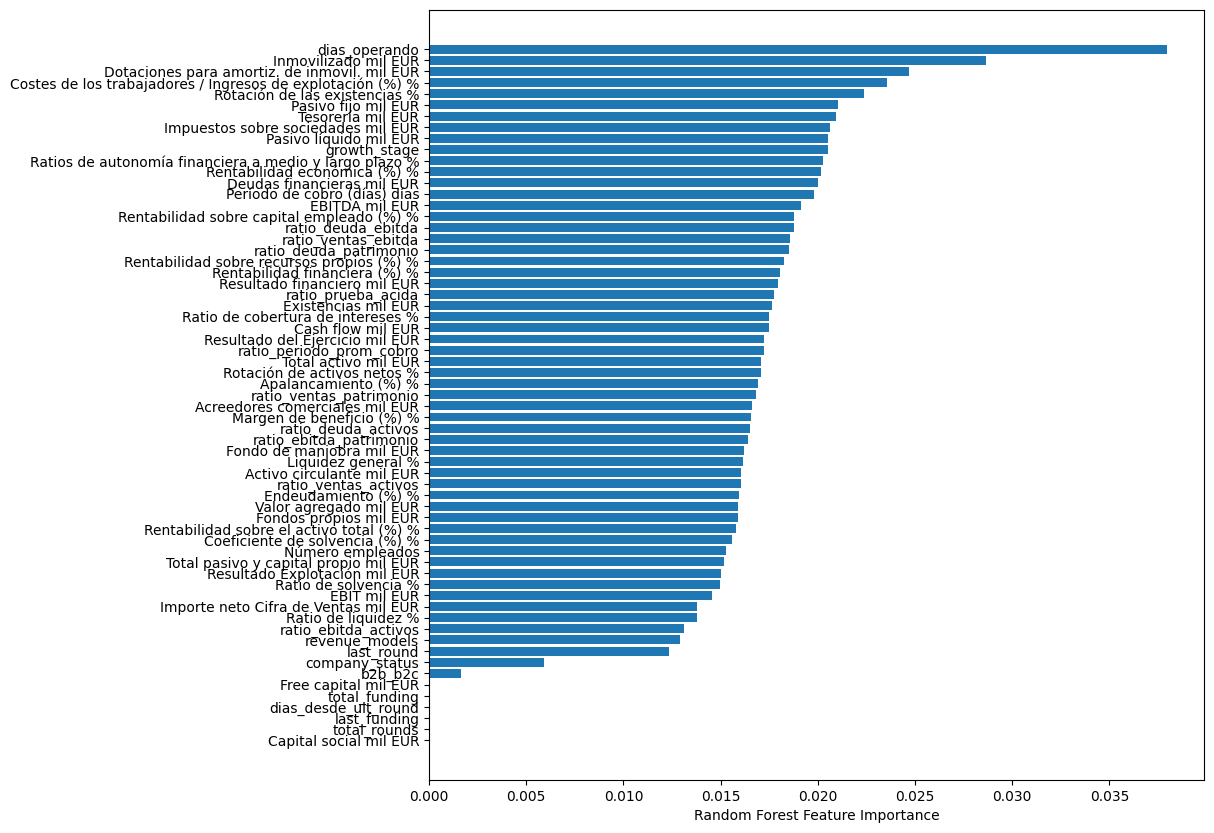

In [481]:
df_clasif_imp=vars_importantes_rf_clasif(df_clasif,0.017)

{'Capital social mil EUR': 0.03, 'total_funding': 0.02, 'last_funding': 0.02, 'last_round': 0.01, 'total_rounds': 0.01, 'ownerships': 0.01, 'b2b_b2c': 0.0, 'revenue_models': 0.01, 'growth_stage': 0.01, 'company_status': 0.01, 'year': 0.0, 'Número empleados': 0.02, 'Inmovilizado mil EUR': 0.02, 'Activo circulante mil EUR': 0.02, 'Total activo mil EUR': 0.03, 'Fondos propios mil EUR': 0.02, 'Pasivo fijo mil EUR': 0.02, 'Pasivo líquido mil EUR': 0.02, 'Total pasivo y capital propio mil EUR': 0.03, 'Resultado Explotación mil EUR': 0.02, 'Resultado financiero mil EUR': 0.02, 'Resultado del Ejercicio mil EUR': 0.02, 'Costes de los trabajadores / Ingresos de explotación (%) %': 0.01, 'Tesorería mil EUR': 0.02, 'Cash flow mil EUR': 0.02, 'Período de cobro (días) días': 0.02, 'Valor agregado mil EUR': 0.02, 'Apalancamiento (%) %': 0.01, 'Endeudamiento (%) %': 0.01, 'Margen de beneficio (%) %': 0.01, 'Ratio de liquidez %': 0.02, 'Ratio de solvencia %': 0.01, 'Rentabilidad económica (%) %': 0.01,

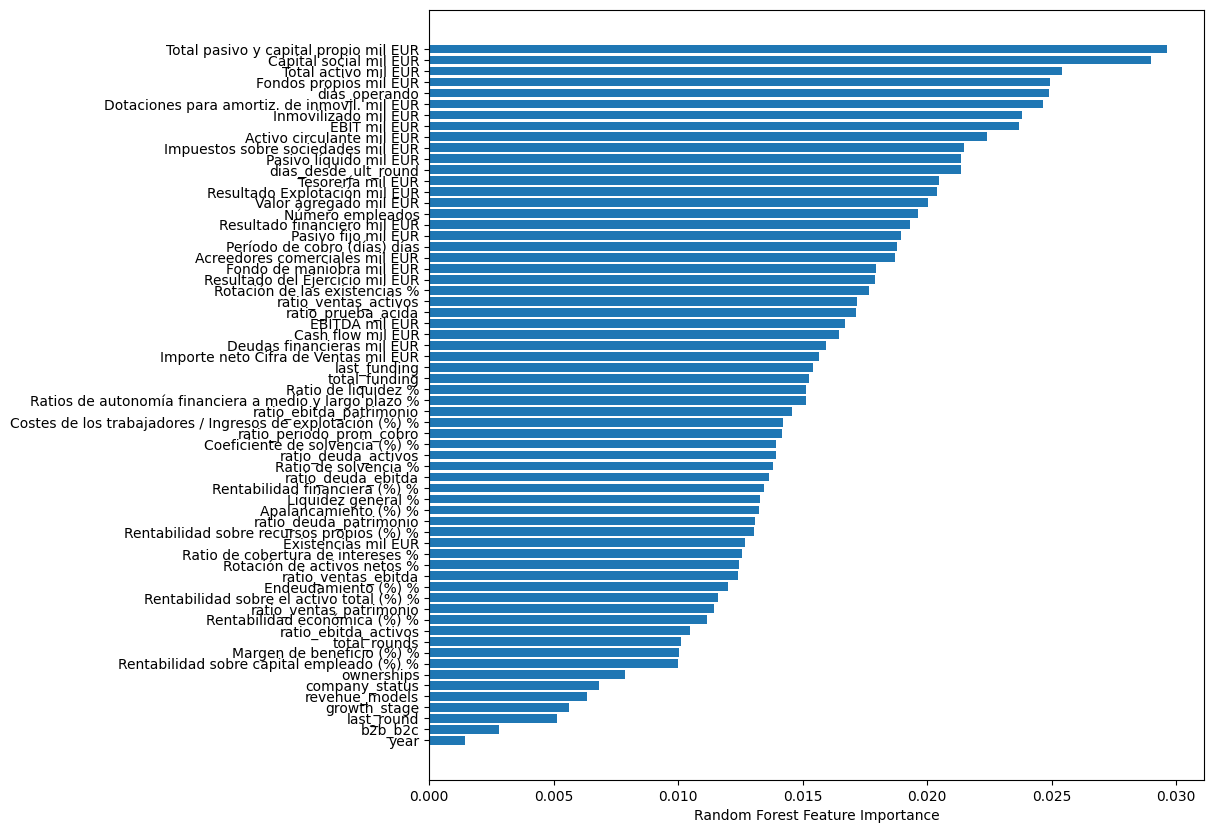

In [482]:
df_clasif_pref_imp=vars_importantes_rf_clasif(df_clasif_prefusion,0.017 )

* Variables ratios

In [483]:
df_clasif_ratio = df_clasif.filter(regex='^(ratio|Porcentaje)')
print(f'Contiene {df_clasif_ratio.shape[1]} columnas')
df_clasif_pref_ratio = df_clasif_prefusion.filter(regex='^(ratio|Porcentaje)')
print(f'Contiene {df_clasif_pref_ratio.shape[1]} columnas')

Contiene 11 columnas
Contiene 11 columnas


### 1.4 Escalado

In [484]:
df_originales=[df_clasif_cor, df_clasif_pref_cor, df_clasif_imp, df_clasif_pref_imp, df_clasif_ratio, df_clasif_pref_ratio ]
df_originales_nombre=['df_clasif_cor', 'df_clasif_pref_cor', 'df_clasif_imp', 'df_clasif_pref_imp', 'df_clasif_ratio', 'df_clasif_pref_ratio']

In [485]:
# Crear un objeto StandardScaler

df_clasif_cor_esc, df_clasif_cor_nor = normalizacion_clasif(df_clasif_cor)
df_clasif_pref_cor_esc, df_clasif_pref_cor_nor = normalizacion_clasif(df_clasif_pref_cor)
df_clasif_imp_esc, df_clasif_imp_nor = normalizacion_clasif(df_clasif_imp)
df_clasif_pref_imp_esc, df_clasif_pref_imp_nor = normalizacion_clasif(df_clasif_pref_imp)
df_clasif_ratio_esc, df_clasif_ratio_nor = normalizacion_clasif(df_clasif_ratio)
df_clasif_pref_ratio_esc, df_clasif_pref_ratio_nor = normalizacion_clasif(df_clasif_pref_ratio)

df_lista=[df_clasif_cor_esc, df_clasif_cor_nor,df_clasif_pref_cor_esc, df_clasif_pref_cor_nor,df_clasif_imp_esc, df_clasif_imp_nor,df_clasif_pref_imp_esc, df_clasif_pref_imp_nor,
          df_clasif_ratio_esc, df_clasif_ratio_nor,df_clasif_pref_ratio_esc, df_clasif_pref_ratio_nor]

df_lista_nombre=['df_clasif_cor_esc', 'df_clasif_cor_nor','df_clasif_pref_cor_esc', 'df_clasif_pref_cor_nor','df_clasif_imp_esc', 'df_clasif_imp_nor','df_clasif_pref_imp_esc', 'df_clasif_pref_imp_nor',
          'df_clasif_ratio_esc', 'df_clasif_ratio_nor','df_clasif_pref_ratio_esc', 'df_clasif_pref_ratio_nor']

## 2. Modelos simples

In [486]:
warnings.filterwarnings('ignore')

In [487]:
i=0
for df in df_originales:
    print(df_originales_nombre[i])
    probar_dataset_clasif(df, TomekLinks())
    i+=1

df_clasif_cor
            
RandomForestClassifier
RandomForestClassifier : 0.5124 
 [[32 15  3]
 [12 27  5]
 [11 13  3]] 
 ------------------------------


SGDClassifier
SGDClassifier : 0.3306 
 [[13 17 20]
 [13 18 13]
 [ 7 11  9]] 
 ------------------------------


SVC
SVC : 0.3636 
 [[ 0 50  0]
 [ 0 44  0]
 [ 0 27  0]] 
 ------------------------------


KNeighborsClassifier
KNeighborsClassifier : 0.4132 
 [[26 19  5]
 [20 17  7]
 [11  9  7]] 
 ------------------------------


DecisionTreeClassifier
DecisionTreeClassifier : 0.4298 
 [[27  7 16]
 [18 17  9]
 [ 5 14  8]] 
 ------------------------------


GaussianNB
GaussianNB : 0.2645 
 [[ 4 16 30]
 [ 2 10 32]
 [ 2  7 18]] 
 ------------------------------


Mejor modelo: RandomForestClassifier(random_state=42) , que tiene un accuracy de: 0.5124
              
df_clasif_pref_cor
            
RandomForestClassifier
RandomForestClassifier : 0.6939 
 [[68 15  2]
 [19 84  2]
 [16 21 18]] 
 ------------------------------


SGDClassifier
SGDC

In [488]:
i=0
for df in df_lista:
    print(df_lista_nombre[i])
    probar_dataset_clasif(df, SMOTEENN())
    i+=1

df_clasif_cor_esc
            
RandomForestClassifier
RandomForestClassifier : 0.3471 
 [[ 7 10 33]
 [ 2 20 22]
 [ 4  8 15]] 
 ------------------------------


SGDClassifier
SGDClassifier : 0.3554 
 [[ 7  4 39]
 [ 8 18 18]
 [ 1  8 18]] 
 ------------------------------


SVC
SVC : 0.2893 
 [[ 0  6 44]
 [ 0 14 30]
 [ 0  6 21]] 
 ------------------------------


KNeighborsClassifier
KNeighborsClassifier : 0.4298 
 [[20  7 23]
 [ 6 14 24]
 [ 4  5 18]] 
 ------------------------------


DecisionTreeClassifier
DecisionTreeClassifier : 0.3223 
 [[15  6 29]
 [ 8 14 22]
 [ 9  8 10]] 
 ------------------------------


GaussianNB
GaussianNB : 0.4793 
 [[28 18  4]
 [12 27  5]
 [ 8 16  3]] 
 ------------------------------


Mejor modelo: GaussianNB() , que tiene un accuracy de: 0.4793
              
df_clasif_cor_nor
            
RandomForestClassifier
RandomForestClassifier : 0.3636 
 [[ 6 21 23]
 [ 4 20 20]
 [ 1  8 18]] 
 ------------------------------


SGDClassifier
SGDClassifier : 0.4711 
 [[2

In [489]:
print(f'El mejor dataset para clasificación de los tres probados es: {"df_clasif_cor"}')

El mejor dataset para clasificación de los tres probados es: df_clasif_cor


# 3.- Automated ML

In [490]:
X = df_clasif_cor.drop(columns=['Porcentaje_adquisicion_cat'])
y = df_clasif_cor['Porcentaje_adquisicion_cat']

X, y = SMOTEENN(random_state=0).fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




                                                                             
Generation 1 - Current best internal CV score: 0.9119047619047618
                                                                              
Generation 2 - Current best internal CV score: 0.9119047619047618
                                                                              
Generation 3 - Current best internal CV score: 0.9119047619047618
                                                                              
Generation 4 - Current best internal CV score: 0.9119047619047618
                                                                              
Generation 5 - Current best internal CV score: 0.9119047619047618
                                                                              
Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=3, p=1, weights=distance)
Classification report for classifier TPOTClassifier(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, rand

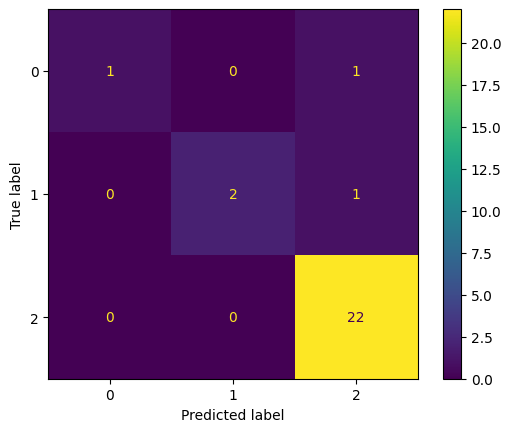

0.9259259259259259

In [491]:
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from tpot import TPOTClassifier

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)
model = TPOTClassifier(generations=5, population_size=50, cv=cv, scoring='accuracy', verbosity=2, random_state=RANDOM_STATE, n_jobs=7)
# perform the search
model.fit(X_train, y_train)
prediccion_clasif(model, X_test, y_test)

## 3. Grid search del mejor modelo

In [492]:
model_list=[KNeighborsClassifier(), DecisionTreeClassifier(random_state=0), SVC(),  SGDClassifier()]

model_hyperparameters={"kn":{
    "n_neighbors": [3,5,7],
    "leaf_size": [15,30],
    'weights':['uniform', 'distance']
},
"tree_clas":{
    "max_depth":[None, 3, 5,10],
    'min_samples_split':[0,2,5,10]
},
"svc":{
    'kernel':['linear', 'rbf'],
    "C":[1,3,5],
    "gamma":["scale", "auto"]
},


'sgdc':{
    "loss":['squared_error', 'log']
}
}

In [493]:
entrenamiento_clasif(xtr=X_train, ytr=y_train, models_list=model_list, model_hyperparameters=model_hyperparameters)

{'model_used': KNeighborsClassifier(), 'highest_score': 0.9192307692307692, 'best hyperparameters': {'leaf_size': 15, 'n_neighbors': 5, 'weights': 'distance'}}
{'model_used': DecisionTreeClassifier(random_state=0), 'highest_score': 0.8538461538461538, 'best hyperparameters': {'max_depth': None, 'min_samples_split': 5}}
{'model_used': SVC(), 'highest_score': 0.9192307692307692, 'best hyperparameters': {'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}}
{'model_used': SGDClassifier(), 'highest_score': 0.6294871794871795, 'best hyperparameters': {'loss': 'log'}}


In [494]:
modelo_simple_clasif(SVC(C= 3, gamma= 'scale', kernel= 'rbf'), X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

SVC
SVC : 0.8889 
 [[ 1  0  1]
 [ 0  1  2]
 [ 0  0 22]] 
 ------------------------------




(SVC(C=3), 0.8889)

## 4. Ensemble learning

## 4.1 Stacking

Classification report for classifier StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('svm', SVC(random_state=42)),
                               ('knn', KNeighborsClassifier()),
                               ('dt', DecisionTreeClassifier(random_state=42)),
                               ('sgd', SGDClassifier(random_state=42))],
                   final_estimator=LogisticRegression(random_state=42)):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.0000    0.0000    0.0000         3
           2     0.8182    0.8182    0.8182        22

    accuracy                         0.6667        27
   macro avg     0.2727    0.2727    0.2727        27
weighted avg     0.6667    0.6667    0.6667        27


Confusion matrix:
[[ 0  1  1]
 [ 0  0  3]
 [ 0  4 18]]


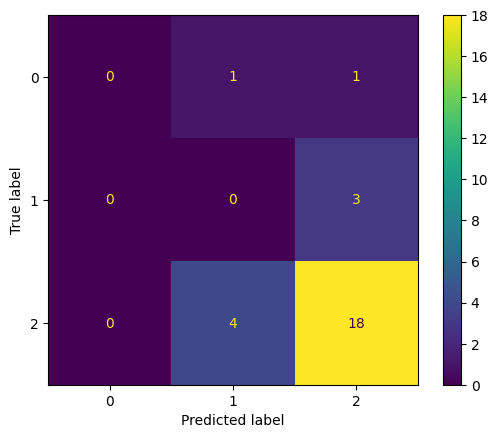

0.6666666666666666

In [495]:
from sklearn.ensemble import StackingClassifier

# level 0
level0 = list()
level0.append(('lr', LogisticRegression(random_state=RANDOM_STATE)))
level0.append(('svm', SVC(random_state=RANDOM_STATE)))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('dt', DecisionTreeClassifier(random_state=RANDOM_STATE)))
level0.append(('sgd', SGDClassifier(random_state=RANDOM_STATE)))

# level 1 - meta model
level1 = LogisticRegression(random_state=RANDOM_STATE)

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
model.fit(X_train, y_train)
prediccion_clasif(model, X_test, y_test)

* Optimizacion

In [496]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.model_selection import cross_val_score
from hyperopt import space_eval

space = {
    "lr__C": hp.uniform("lr__C", 0.01, 1.0),
    "knn__n_neighbors" : hp.randint("knn__n_neighbors", 1, 11),
    "cart__max_depth" : hp.randint("cart__max_depth", 1, 4),
    "svm__C":  hp.uniform("svm__C", 0.01, 1.0),
    "final_estimator__solver": hp.choice("final_estimator__solver", ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
    "final_estimator__C": hp.uniform("final_estimator__C", 0.01, 1.0),
    "final_estimator__class_weight": hp.choice("final_estimator__class_weight", ["balanced", None])}


def objective(space):

    # level 0
    level0 = list()
    level0.append(('lr', LogisticRegression(random_state=RANDOM_STATE, C = space['lr__C'])))
    level0.append(('svm', SVC(random_state=RANDOM_STATE, C = space['svm__C'])))
    level0.append(('knn', KNeighborsClassifier(n_neighbors = space['knn__n_neighbors'])))
    level0.append(('dt', DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth = space['cart__max_depth'])))

    # level 1 - meta model
    level1 = LogisticRegression(random_state=RANDOM_STATE, solver = space['final_estimator__solver'], C = space['final_estimator__C'], class_weight = space['final_estimator__class_weight'])

    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    score = cross_val_score(model, X_train, y_train, cv=5).mean()
    return{'loss':-score, 'status':STATUS_OK}

In [497]:
trials = Trials()
best = fmin(fn= objective,
    space= space,
    algo= tpe.suggest,
    max_evals = 25,
    trials= trials)
print("best: {}".format(best))

100%|██████████| 25/25 [00:26<00:00,  1.07s/trial, best loss: -0.887179487179487] 
best: {'cart__max_depth': 1, 'final_estimator__C': 0.9561893857219461, 'final_estimator__class_weight': 1, 'final_estimator__solver': 3, 'knn__n_neighbors': 1, 'lr__C': 0.3164320125812885, 'svm__C': 0.15272776382965814}


Classification report for classifier StackingClassifier(cv=5,
                   estimators=[('lr',
                                LogisticRegression(C=0.3164320125812885,
                                                   random_state=42)),
                               ('svm',
                                SVC(C=0.15272776382965814, random_state=42)),
                               ('knn', KNeighborsClassifier(n_neighbors=1)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=1,
                                                       random_state=42))],
                   final_estimator=LogisticRegression(C=0.9561893857219461,
                                                      random_state=42,
                                                      solver='sag')):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     1.0000    1.0000    1.0000         3
  

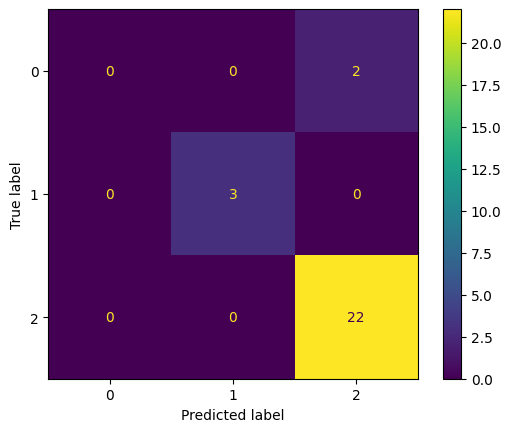

0.9259259259259259

In [498]:
best_stacking = space_eval(space, best)


# level 0
level0 = list()
level0.append(('lr', LogisticRegression(random_state=RANDOM_STATE, C = best_stacking['lr__C'])))
level0.append(('svm', SVC(random_state=RANDOM_STATE, C = best_stacking['svm__C'])))
level0.append(('knn', KNeighborsClassifier(n_neighbors = best_stacking['knn__n_neighbors'])))
level0.append(('dt', DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth = best_stacking['cart__max_depth'])))

# level 1 - meta model
level1 = LogisticRegression(random_state=RANDOM_STATE, solver = best_stacking['final_estimator__solver'], C = best_stacking['final_estimator__C'], class_weight = best_stacking['final_estimator__class_weight'])

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
model.fit(X_train, y_train)
prediccion_clasif(model, X_test, y_test)

## 4.2 Bagging

### BagginClasifier

In [499]:
from sklearn.ensemble import BaggingClassifier

logistic_regression = LogisticRegression(random_state=RANDOM_STATE)
svc = SVC(random_state=RANDOM_STATE)
knn = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
sgd=SGDClassifier(random_state=RANDOM_STATE)
gaussian_nb = GaussianNB()


models = [logistic_regression, knn, decision_tree, sgd, gaussian_nb, svc]
for model in models:
  
    bc = BaggingClassifier(random_state=RANDOM_STATE, base_estimator=model)
    bc.fit(X_train, y_train)
    predictions = bc.predict(X_test)

    print(model.__class__.__name__, ':', round(accuracy_score(y_test, predictions),4), '\n', confusion_matrix(y_test, predictions),'\n', '-'*30)

LogisticRegression : 0.8519 
 [[ 1  0  1]
 [ 0  3  0]
 [ 1  2 19]] 
 ------------------------------
KNeighborsClassifier : 0.8519 
 [[ 0  0  2]
 [ 0  1  2]
 [ 0  0 22]] 
 ------------------------------
DecisionTreeClassifier : 0.9259 
 [[ 1  0  1]
 [ 1  2  0]
 [ 0  0 22]] 
 ------------------------------
SGDClassifier : 0.7407 
 [[ 0  1  1]
 [ 0  1  2]
 [ 3  0 19]] 
 ------------------------------
GaussianNB : 0.7407 
 [[ 0  1  1]
 [ 0  2  1]
 [ 2  2 18]] 
 ------------------------------
SVC : 0.8889 
 [[ 1  0  1]
 [ 0  1  2]
 [ 0  0 22]] 
 ------------------------------


### Random Forest

Classification report for classifier RandomForestClassifier(random_state=42):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     1.0000    1.0000    1.0000         3
           2     0.9167    1.0000    0.9565        22

    accuracy                         0.9259        27
   macro avg     0.6389    0.6667    0.6522        27
weighted avg     0.8580    0.9259    0.8905        27


Confusion matrix:
[[ 0  0  2]
 [ 0  3  0]
 [ 0  0 22]]


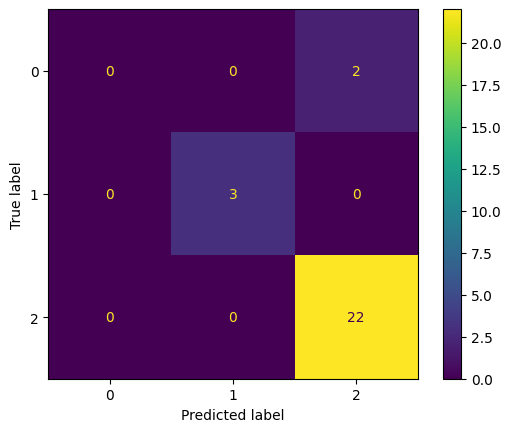

0.9259259259259259

In [500]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
prediccion_clasif(rf, X_test, y_test)

* Optimizacion

In [501]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.model_selection import cross_val_score
from hyperopt import space_eval

space = {
'criterion': hp.choice('criterion', ['entropy', 'gini']),
'max_depth': hp.quniform('max_depth', 10, 1200, 10),
'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
'n_estimators' : hp.randint('n_estimators', 0, 2000)
}

def objective(space):
   
    model = RandomForestClassifier(criterion = space['criterion'], 
        #max_depth = space['max_depth'],
        max_features = space['max_features'],
        min_samples_leaf = space['min_samples_leaf'],
        min_samples_split = space['min_samples_split'],
        n_estimators = space['n_estimators'])
        
    accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()
    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

In [502]:
trials = Trials()
best = fmin(fn= objective,
    space= space,
    algo= tpe.suggest,
    max_evals = 25,
    trials= trials)
print("best: {}".format(best))

100%|██████████| 25/25 [01:46<00:00,  4.24s/trial, best loss: -0.8076923076923077]
best: {'criterion': 0, 'max_depth': 690.0, 'max_features': 3, 'min_samples_leaf': 0.35101268733634844, 'min_samples_split': 0.9703016229623985, 'n_estimators': 282}


Classification report for classifier RandomForestClassifier(criterion='entropy', max_depth=690, max_features=None,
                       min_samples_leaf=0.35101268733634844,
                       min_samples_split=0.9703016229623985, n_estimators=282):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.0000    0.0000    0.0000         3
           2     0.8148    1.0000    0.8980        22

    accuracy                         0.8148        27
   macro avg     0.2716    0.3333    0.2993        27
weighted avg     0.6639    0.8148    0.7317        27


Confusion matrix:
[[ 0  0  2]
 [ 0  0  3]
 [ 0  0 22]]


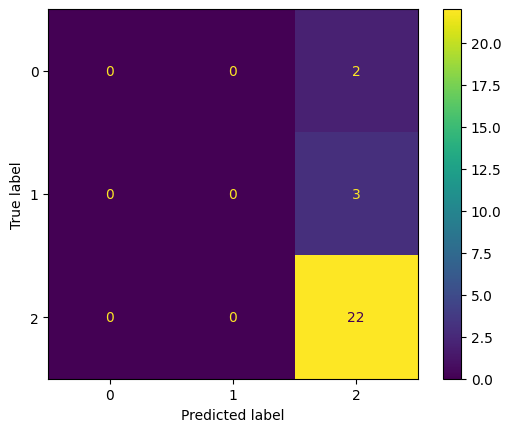

0.8148148148148148

In [503]:
best_rf = space_eval(space, best)


rf = RandomForestClassifier(criterion=best_rf['criterion'], 
        max_depth=int(best_rf['max_depth']), 
        max_features=best_rf['max_features'], 
        min_samples_leaf=best_rf['min_samples_leaf'], 
        min_samples_split=best_rf['min_samples_split'], 
        n_estimators=best_rf['n_estimators'])

rf.fit(X_train, y_train)

prediccion_clasif(rf, X_test, y_test)

# Extra Randimised trees

Classification report for classifier ExtraTreesClassifier(random_state=42):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     1.0000    1.0000    1.0000         3
           2     0.9167    1.0000    0.9565        22

    accuracy                         0.9259        27
   macro avg     0.6389    0.6667    0.6522        27
weighted avg     0.8580    0.9259    0.8905        27


Confusion matrix:
[[ 0  0  2]
 [ 0  3  0]
 [ 0  0 22]]


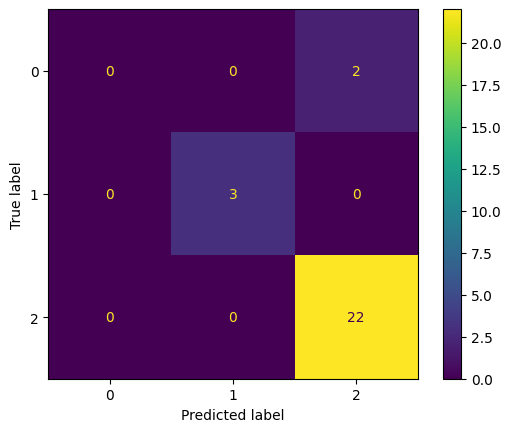

0.9259259259259259

In [504]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(random_state=RANDOM_STATE, )
et.fit(X_train, y_train)
prediccion_clasif(et, X_test, y_test)

* Optimización

In [505]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.model_selection import cross_val_score
from hyperopt import space_eval

space = {
'criterion': hp.choice('criterion', ['entropy', 'gini']),
'max_depth': hp.quniform('max_depth', 10, 1200, 10),
'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
'n_estimators' : hp.randint('n_estimators', 0, 2000)
}

def objective(space):

    model = ExtraTreesClassifier(criterion = space['criterion'], 
        #max_depth = space['max_depth'],
        max_features = space['max_features'],
        min_samples_leaf = space['min_samples_leaf'],
        min_samples_split = space['min_samples_split'],
        n_estimators = space['n_estimators'])
        
    accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()

    return {'loss': -accuracy, 'status': STATUS_OK }

In [506]:
trials = Trials()
best = fmin(fn= objective,
    space= space,
    algo= tpe.suggest,
    max_evals = 25,
    trials= trials)
print("best: {}".format(best))

100%|██████████| 25/25 [01:27<00:00,  3.51s/trial, best loss: -0.8230769230769232]
best: {'criterion': 1, 'max_depth': 1050.0, 'max_features': 3, 'min_samples_leaf': 0.043946026726859655, 'min_samples_split': 0.5325576275532661, 'n_estimators': 1144}


Classification report for classifier ExtraTreesClassifier(max_depth=1050, max_features=None,
                     min_samples_leaf=0.043946026726859655,
                     min_samples_split=0.5325576275532661, n_estimators=1144):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     1.0000    0.3333    0.5000         3
           2     0.8462    1.0000    0.9167        22

    accuracy                         0.8519        27
   macro avg     0.6154    0.4444    0.4722        27
weighted avg     0.8006    0.8519    0.8025        27


Confusion matrix:
[[ 0  0  2]
 [ 0  1  2]
 [ 0  0 22]]


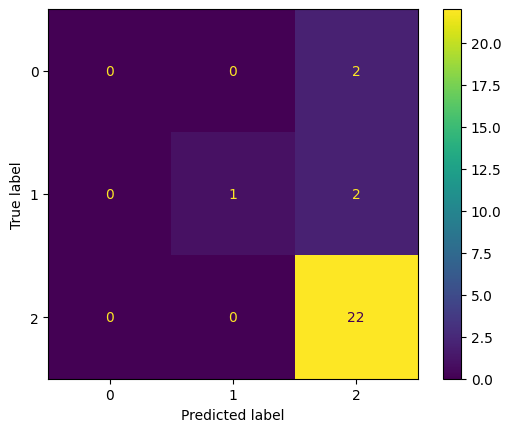

0.8518518518518519

In [507]:
best_rf = space_eval(space, best)


rf = ExtraTreesClassifier(criterion=best_rf['criterion'], 
        max_depth=int(best_rf['max_depth']), 
        max_features=best_rf['max_features'], 
        min_samples_leaf=best_rf['min_samples_leaf'], 
        min_samples_split=best_rf['min_samples_split'], 
        n_estimators=best_rf['n_estimators'])

rf.fit(X_train, y_train)

prediccion_clasif(rf, X_test, y_test)

## 4.3 Boosting

### Adaboost

Classification report for classifier AdaBoostClassifier(random_state=42):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     1.0000    0.6667    0.8000         3
           2     0.8800    1.0000    0.9362        22

    accuracy                         0.8889        27
   macro avg     0.6267    0.5556    0.5787        27
weighted avg     0.8281    0.8889    0.8517        27


Confusion matrix:
[[ 0  0  2]
 [ 0  2  1]
 [ 0  0 22]]


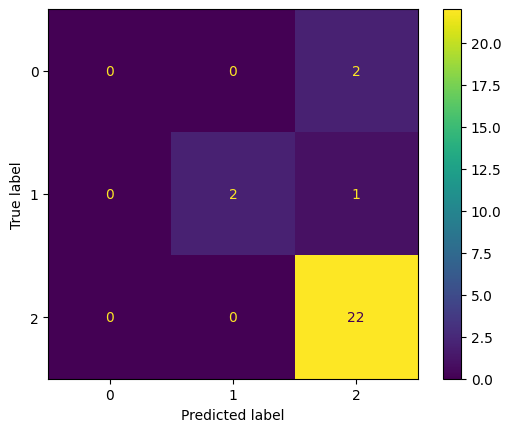

0.8888888888888888

In [508]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(random_state=RANDOM_STATE)
ada.fit(X_train, y_train)
prediccion_clasif(ada, X_test, y_test)

* Optimizacion

In [509]:
space = {'n_estimators': hp.quniform('n_estimators', 10, 1200, 10),
'learning_rate': hp.uniform('learning_rate', 0.01, 1),
}

def objective(space):

    model = AdaBoostClassifier(n_estimators = int(space['n_estimators']),
        learning_rate = space['learning_rate'])
        
    accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()

    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()
best = fmin(fn= objective,
    space= space,
    algo= tpe.suggest,
    max_evals = 25,
    trials= trials)

print("best: {}".format(best))

100%|██████████| 25/25 [01:37<00:00,  3.91s/trial, best loss: -0.8538461538461538]
best: {'learning_rate': 0.11606147424223359, 'n_estimators': 600.0}


Classification report for classifier AdaBoostClassifier(learning_rate=0.11606147424223359, n_estimators=600):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.6667    0.6667    0.6667         3
           2     0.9167    1.0000    0.9565        22

    accuracy                         0.8889        27
   macro avg     0.5278    0.5556    0.5411        27
weighted avg     0.8210    0.8889    0.8535        27


Confusion matrix:
[[ 0  1  1]
 [ 0  2  1]
 [ 0  0 22]]


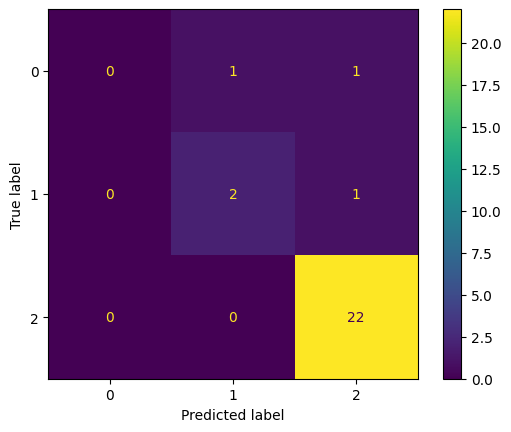

In [510]:
best=space_eval(space, best)

ada = AdaBoostClassifier(n_estimators=int(best['n_estimators']),
        learning_rate=best['learning_rate'])

ada.fit(X_train, y_train)
prediccion_clasif(ada, X_test, y_test)

with open('adaboost_clasificacion.sav', 'wb') as f:
    pickle.dump(ada, f)

### Gradient Descent Boosting

Classification report for classifier GradientBoostingClassifier(random_state=42):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     1.0000    1.0000    1.0000         3
           2     0.9130    0.9545    0.9333        22

    accuracy                         0.8889        27
   macro avg     0.6377    0.6515    0.6444        27
weighted avg     0.8551    0.8889    0.8716        27


Confusion matrix:
[[ 0  0  2]
 [ 0  3  0]
 [ 1  0 21]]


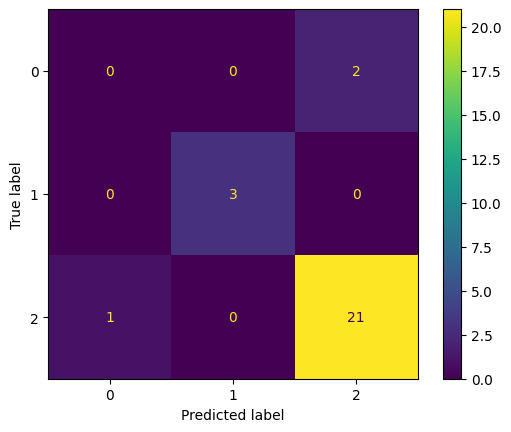

0.8888888888888888

In [511]:
from sklearn.ensemble import GradientBoostingClassifier

params = {
    "n_estimators": 1000,
}

gbc = GradientBoostingClassifier(random_state=RANDOM_STATE)
gbc.fit(X_train, y_train)
prediccion_clasif(gbc, X_test, y_test)

* Optimización

In [512]:

space = { 
'n_estimators': hp.quniform('n_esimator', 10, 100,10),
'learning_rate': hp.quniform('learning_rate', 0.1,1,0.1),
'min_samples_split':hp.quniform('min_samples_split', 2,30,4),
'min_samples_leaf':hp.quniform('min_samples_leaf', 2,21,3)
}
def objective(space):
    model = GradientBoostingClassifier(n_estimators= int(round(space['n_estimators'])), learning_rate=space['learning_rate'],
                                       min_samples_split=round(space['min_samples_split']) , min_samples_leaf=int(round(space['min_samples_leaf'])))
    accuracy = cross_val_score(model, X_train, y_train, cv = 5, scoring='neg_mean_absolute_percentage_error').mean()

    return {'loss': abs(accuracy), 'status': STATUS_OK } 

In [513]:

trials = Trials()
best = fmin(fn= objective,
space= space, 
algo= tpe.suggest, 
max_evals = 10, 
trials= trials)
print("best: {}".format(best))

100%|██████████| 10/10 [00:05<00:00,  1.87trial/s, best loss: 502324573822093.8]
best: {'learning_rate': 0.8, 'min_samples_leaf': 3.0, 'min_samples_split': 24.0, 'n_esimator': 90.0}


Classification report for classifier GradientBoostingClassifier(learning_rate=0.8, min_samples_leaf=3,
                           min_samples_split=24, n_estimators=90):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     1.0000    0.6667    0.8000         3
           2     0.9130    0.9545    0.9333        22

    accuracy                         0.8519        27
   macro avg     0.6377    0.5404    0.5778        27
weighted avg     0.8551    0.8519    0.8494        27


Confusion matrix:
[[ 0  0  2]
 [ 1  2  0]
 [ 1  0 21]]


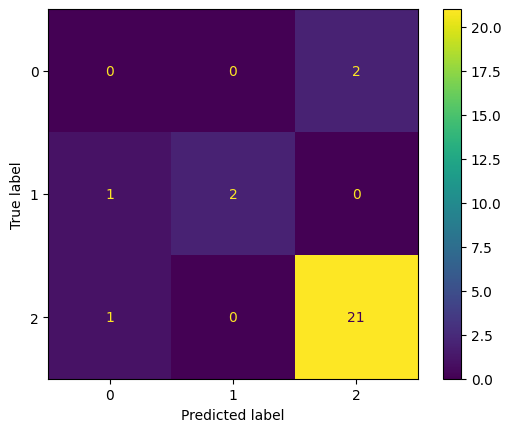

0.8518518518518519

In [514]:
best_rf = space_eval(space, best)

et = GradientBoostingClassifier(n_estimators= round(best_rf['n_estimators']), learning_rate=best_rf['learning_rate'],
                                       min_samples_split=round(best_rf['min_samples_split']) , min_samples_leaf=round(best_rf['min_samples_leaf']))
et.fit(X_train, y_train)
prediccion_clasif(et, X_test, y_test)

## HistgradientBoosting

Classification report for classifier HistGradientBoostingClassifier(random_state=42):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.0000    0.0000    0.0000         3
           2     0.8077    0.9545    0.8750        22

    accuracy                         0.7778        27
   macro avg     0.2692    0.3182    0.2917        27
weighted avg     0.6581    0.7778    0.7130        27


Confusion matrix:
[[ 0  0  2]
 [ 0  0  3]
 [ 0  1 21]]


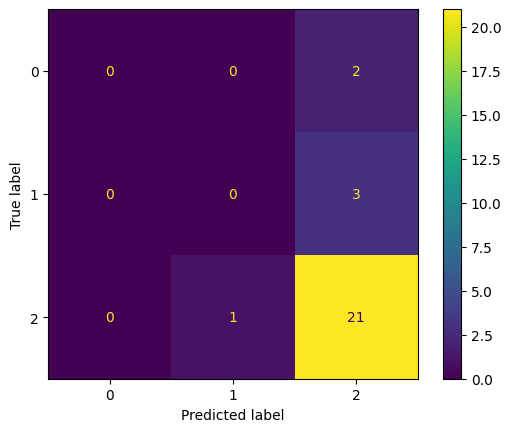

0.7777777777777778

In [515]:
from sklearn.ensemble import HistGradientBoostingClassifier

params = {
    "n_estimators": 1000,
}

gbc = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
gbc.fit(X_train, y_train)
prediccion_clasif(gbc, X_test, y_test)

* Optimizacion

In [516]:

space = { 
'loss': hp.choice('loss', ['log_loss','auto' ]),
'learning_rate': hp.quniform('learning_rate', 0.1,1,0.1),
'max_depth': hp.quniform('max_depth', 10, 1200, 10),
'min_samples_leaf':hp.quniform('min_samples_leaf', 2,21,3)
}
def objective(space):
    model = HistGradientBoostingClassifier( loss= space['loss'], learning_rate=space['learning_rate'],
                                       max_depth=round(space['max_depth']) , min_samples_leaf=int(round(space['min_samples_leaf'])))
    accuracy = cross_val_score(model, X_train, y_train, cv = 5, scoring='neg_mean_absolute_percentage_error').mean()

    return {'loss': abs(accuracy), 'status': STATUS_OK } 

In [517]:

trials = Trials()
best = fmin(fn= objective,
space= space, 
algo= tpe.suggest, 
max_evals = 10, 
trials= trials)
print("best: {}".format(best))

100%|██████████| 10/10 [00:11<00:00,  1.17s/trial, best loss: 352204586243077.6]
best: {'learning_rate': 0.9, 'loss': 0, 'max_depth': 550.0, 'min_samples_leaf': 3.0}


Classification report for classifier HistGradientBoostingClassifier(learning_rate=0.9, min_samples_leaf=3):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.0000    0.0000    0.0000         3
           2     0.4286    0.1364    0.2069        22

    accuracy                         0.1111        27
   macro avg     0.1429    0.0455    0.0690        27
weighted avg     0.3492    0.1111    0.1686        27


Confusion matrix:
[[ 0  0  2]
 [ 1  0  2]
 [17  2  3]]


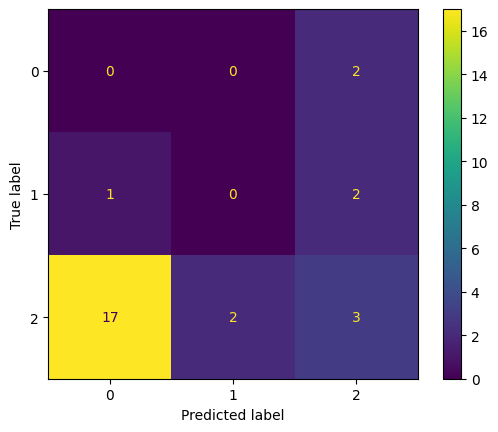

0.1111111111111111

In [518]:
best_gb = space_eval(space, best)

gb = HistGradientBoostingClassifier(loss= best_gb['loss'], learning_rate=best_gb['learning_rate'],
                                        min_samples_leaf=round(best_gb['min_samples_leaf']))
gb.fit(X_train, y_train)
prediccion_clasif(gb, X_test, y_test)

### XGBOOST

Classification report for classifier XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.6667    0.6667    0.6667         3
           2     0.9130    0.9545    0

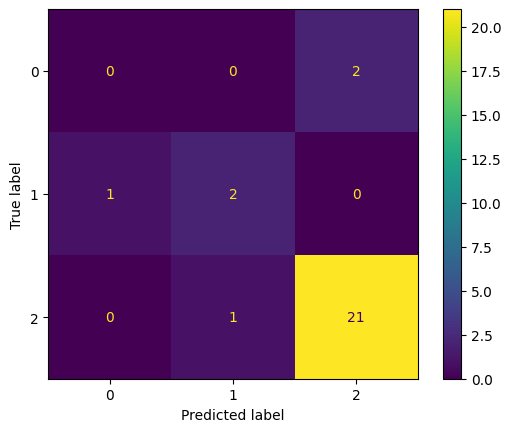

0.8518518518518519

In [519]:
# XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=RANDOM_STATE)
xgb.fit(X_train, y_train)
prediccion_clasif(xgb, X_test, y_test)

* Optimizacion

In [520]:
# Optimize XGBoost

space = {'n_estimators': hp.quniform('n_estimators', 10, 1200, 10),
'learning_rate': hp.uniform('learning_rate', 0.01, 1),
'max_depth': hp.quniform('max_depth', 10, 1200, 10),
'min_child_weight': hp.uniform('min_child_weight', 0, 1),
'gamma': hp.uniform('gamma', 0, 1),
'subsample': hp.uniform('subsample', 0, 1),
'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
'reg_alpha': hp.uniform('reg_alpha', 0, 1),
'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}
    #X = df_clasif_imp.drop(columns=['Porcentaje_adquisicion_cat'])
    #y = df_clasif_imp['Porcentaje_adquisicion_cat']

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    #X_train, y_train = space['balanceo'].fit_resample(X_train, y_train)
def objective(space):

    model = XGBClassifier(n_estimators = int(space['n_estimators']),
        learning_rate = space['learning_rate'],
        max_depth = int(space['max_depth']),
        min_child_weight = space['min_child_weight'],
        gamma = space['gamma'],
        subsample = space['subsample'],
        colsample_bytree = space['colsample_bytree'],
        reg_alpha = space['reg_alpha'],
        reg_lambda = space['reg_lambda'])
        
    accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()
    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

In [521]:
trials = Trials()
best = fmin(fn= objective,
    space= space,
    algo= tpe.suggest,
    max_evals = 25,
    trials= trials)

print("best: {}".format(best))

100%|██████████| 25/25 [00:45<00:00,  1.84s/trial, best loss: -0.8243589743589743]
best: {'colsample_bytree': 0.4446748148637396, 'gamma': 0.39614683814456053, 'learning_rate': 0.7495444023155816, 'max_depth': 690.0, 'min_child_weight': 0.5597769733120208, 'n_estimators': 520.0, 'reg_alpha': 0.07782578817601837, 'reg_lambda': 0.012891628649227327, 'subsample': 0.2696324985575661}


Classification report for classifier XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4446748148637396, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.39614683814456053, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.7495444023155816, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=690, max_leaves=None,
              min_child_weight=0.5597769733120208, missing=nan,
              monotone_constraints=None, n_estimators=520, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
        

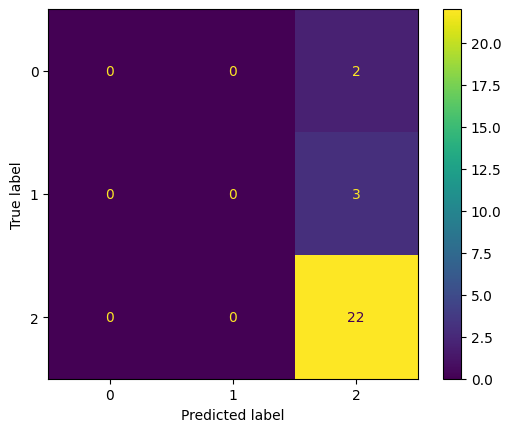

0.8148148148148148

In [522]:
best=space_eval(space, best)

xgb = XGBClassifier(n_estimators=int(best['n_estimators']),
        learning_rate=best['learning_rate'],
        max_depth=int(best['max_depth']),
        min_child_weight=best['min_child_weight'],
        gamma=best['gamma'],
        subsample=best['subsample'],
        colsample_bytree=best['colsample_bytree'],
        reg_alpha=best['reg_alpha'],
        reg_lambda=best['reg_lambda'])

xgb.fit(X_train, y_train)
prediccion_clasif(xgb, X_test, y_test)

### CATBOOST

Classification report for classifier <catboost.core.CatBoostClassifier object at 0x0000018196836F70>:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     1.0000    1.0000    1.0000         3
           2     0.9167    1.0000    0.9565        22

    accuracy                         0.9259        27
   macro avg     0.6389    0.6667    0.6522        27
weighted avg     0.8580    0.9259    0.8905        27


Confusion matrix:
[[ 0  0  2]
 [ 0  3  0]
 [ 0  0 22]]


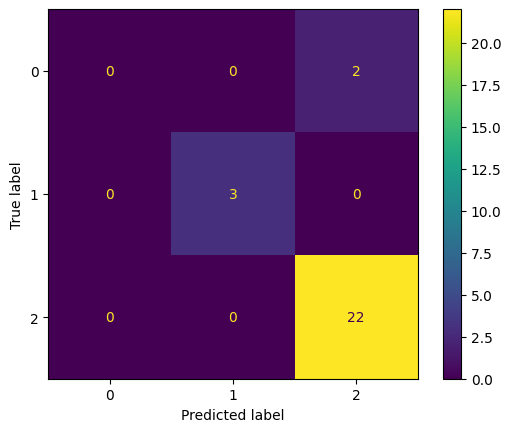

0.9259259259259259

In [523]:
# CatBoost
from catboost import CatBoostClassifier

cat = CatBoostClassifier(random_state=RANDOM_STATE,  silent=True)
cat.fit(X_train, y_train)
prediccion_clasif(cat, X_test, y_test)

* Optmizacion

### LIGHTGBM

Classification report for classifier LGBMClassifier(random_state=42):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.5000    0.3333    0.4000         3
           2     0.8696    0.9091    0.8889        22

    accuracy                         0.7778        27
   macro avg     0.4565    0.4141    0.4296        27
weighted avg     0.7641    0.7778    0.7687        27


Confusion matrix:
[[ 0  0  2]
 [ 1  1  1]
 [ 1  1 20]]


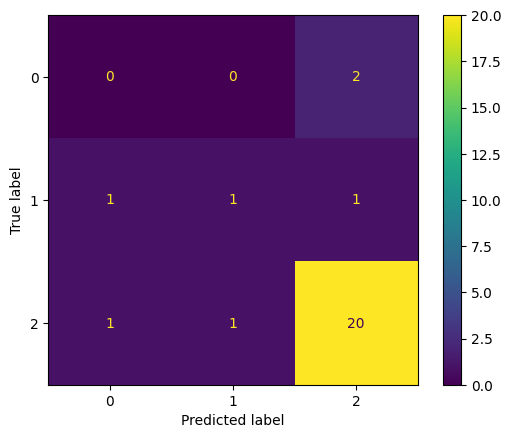

0.7777777777777778

In [524]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(random_state=RANDOM_STATE)
lgbm.fit(X_train, y_train)
prediccion_clasif(lgbm, X_test, y_test)

In [525]:
space = { 
'num_iterations': hp.uniform('num_iterations', 1, 50),
'learning_rate': hp.quniform('learning_rate', 0.1,1,0.1),
'max_depth' :hp.quniform('max_depth', 3,12,3),
'subsample':hp.quniform('subsample', 0.3,1,0.1),
'feature_fraction':hp.quniform('feature_fraction', 0.3,1,0.1)
}
def objective(space):
    model = lgb.LGBMClassifier( num_iterations= round(space['num_iterations']), learning_rate=space['learning_rate'],max_depth=round(space['max_depth']),
                         subsample=space['subsample'],feature_fraction=space['feature_fraction'], random_state=0, silent=True )
    accuracy = cross_val_score(model, X_train, y_train, cv = 5, scoring='neg_mean_absolute_percentage_error').mean()

    return {'loss': abs(accuracy), 'status': STATUS_OK } 

In [526]:
trials = Trials()
best = fmin(fn= objective,
space= space, 
algo= tpe.suggest, 
max_evals = 20, 
trials= trials)
print("best: {}".format(best))

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsamp

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
Classification report for classifier LGBMClassifier(feature_fraction=0.6000000000000001, learning_rate=1.0,
               max_depth=6, num_iterations=9, random_state=42, silent=True,
               subsample=0.4):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.6000    1.0000    0.7500         3
           2     0.9091    0.9091    0.9091        22

    accuracy                         0.8519        27
   macro avg     0.5030    0.6364    0.5530        27
weighted avg     0.8074    0.8519    0.8241        27


Confusion matrix:
[[ 0  0  2]
 [ 0  3  0]
 [ 0  2 20]]


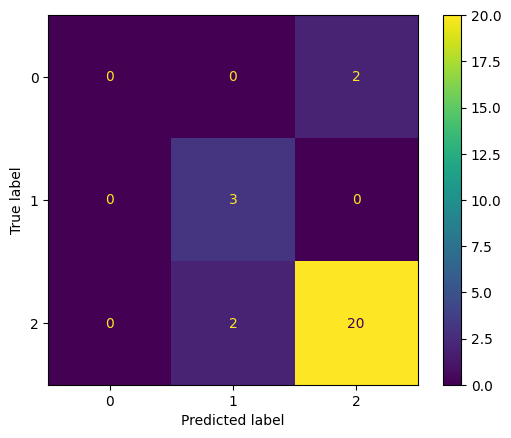

0.8518518518518519

In [527]:
best = space_eval(space, best)

lg = lgb.LGBMClassifier(feature_fraction=best['feature_fraction'],
                        learning_rate=best['learning_rate'],
                        max_depth=round(best['max_depth']),
                        num_iterations=round(best['num_iterations']),
                        subsample=best['subsample'],
                        random_state=RANDOM_STATE,
                        silent=True)
lg.fit(X_train, y_train)
prediccion_clasif(lg, X_test, y_test)